In [61]:
import numpy as np
import pandas as pd
import math
import random
import os
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import gc
import json
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# Sklearn
from sklearn.model_selection import StratifiedKFold
import itertools
# PyTorch 
import torch
# Albumentations for augmentations
import pycocotools.mask as mask_utils
import tifffile as tiff
from itertools import product
import warnings
warnings.filterwarnings("ignore")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

class CFG:
    seed          = 1
    num_fold      = 5

def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    # print('> SEEDING DONE')

def init_logger(log_file='train12.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

set_seed(CFG.seed) 

def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype = np.uint8)
    for m, enc in enumerate(encs):
        if isinstance(enc, float) and np.isnan(enc):
            continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape)

def coordinates_to_masks(coordinates, shape):
    masks = []
    for coord in coordinates:
        mask = np.zeros(shape, dtype=np.uint8)
        cv2.fillPoly(mask, [np.array(coord)], 1)
        masks.append(mask)
    return masks

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle
with open(f"/storage/tungnx/hubmap-hacking-the-human-vasculature/polygons.jsonl", "r") as json_file:
    json_list = list(json_file) 
tiles_data = {}
for json_str in tqdm(json_list, total=len(json_list)):
    json_data = json.loads(json_str)
    tiles_data[json_data['id']] = json_data['annotations']

tile_meta = pd.read_csv(f"/storage/tungnx/hubmap-hacking-the-human-vasculature/tile_meta.csv")
df = tile_meta.query('dataset < 2').reset_index(drop=True)

skf = StratifiedKFold(n_splits=CFG.num_fold, random_state=CFG.seed, shuffle=True)
df['fold'] = -1

for fold, (train_idx, test_idx) in enumerate(skf.split(df, df['source_wsi'])):
    df.loc[test_idx, 'fold'] = fold

print(df.groupby('fold')['source_wsi'].value_counts())

def get_image_path(image_id):
    return f"/storage/tungnx/hubmap-hacking-the-human-vasculature/train/{image_id}.tif"
df['image_path'] = ""
df['height'] = 512
df['width'] = 512
df['image_path'] = df['id'].apply(get_image_path)

df1 = tile_meta.query('dataset ==2').reset_index(drop=True)
df1 = df1.query('no_of_bv > 0').reset_index(drop=True)

df1['image_path'] = ""
df1['height'] = 512
df1['width'] = 512
df1['image_path'] = df1['id'].apply(get_image_path)

print(df.head())
print(len(df))
def get_annotations(df):
    cats = [{"id": 1, "name": "blood_vessels"}]
    annotations = []
    images = []
    obj_count = 1
    index = 1
    for idx, row in tqdm(df.iterrows(), total=len(df)):

        image = cv2.imread(f"/storage/tungnx/hubmap-hacking-the-human-vasculature/train/{row.id}.tif")
        all_cords = []
        ms = []
        H = 512
        W = 512
        for annot in tiles_data[row.id]:
            # print("Annot", annot)
                
            if annot['type'] == "blood_vessel": 
                mask_bv = np.asfortranarray(coordinates_to_masks(annot['coordinates'], (512, 512))[0])
                ms.append(mask_bv)
        ms = np.stack(ms, -1)
        ms_sum = ms.sum((0,1))
        # print(ms.shape, ms_sum)
        cuts = 2
        wstarts = W * np.arange(cuts).astype(int) // (cuts + 1)
        wends = W * np.arange(2, cuts + 2).astype(int) // (cuts + 1)
        hstarts = H * np.arange(cuts).astype(int) // (cuts + 1)
        hends = H * np.arange(2, cuts + 2).astype(int) // (cuts + 1)
        for i, j in product(range(cuts), range(cuts)):
            
            img_cut = image[hstarts[i]:hends[i],wstarts[j]:wends[j]]
            mask_cut = ms[hstarts[i]:hends[i],wstarts[j]:wends[j]]
            mask_cut = mask_cut[...,mask_cut.sum((0,1)) > 0.5 * ms_sum]
            cv2.imwrite(os.path.join("/storage/tungnx/dataset_tiny", f"{row.id}_{i}_{j}.png"), img_cut)
            images.append({
                "id": f"{row.id}_{i}_{j}",
                "file_name": f"/storage/tungnx/dataset_tiny/{row.id}_{i}_{j}.png",
                "width": img_cut.shape[1],
                "height": img_cut.shape[0]
            })
            for l in range(mask_cut.shape[-1]):
                rle = mask_utils.encode(mask_cut[...,l])
                rle['counts'] = rle['counts'].decode()
                bbox = [int(_) for _ in mask_utils.toBbox(rle)]
                area = mask_utils.area(rle)
                annotations.append({
                    "id": len(annotations),
                    "image_id": f"{row.id}_{i}_{j}",
                    "category_id": 1,
                    "bbox": bbox,
                    "segmentation": rle,
                    "iscrowd": 0,
                    "area": int(area)
                })
    return {"categories": cats, "images": images, "annotations": annotations}
fold = 0
train_df = df[df['fold']!=fold]
train_json = get_annotations(train_df)
with open(f"train_tile_fold_{fold}.json", "w+", encoding="utf-8") as f:
    json.dump(train_json, f, ensure_ascii=True, indent=4)

100%|██████████| 1633/1633 [00:08<00:00, 200.18it/s]


fold  source_wsi
0     1             53
      2             31
1     1             53
      2             30
2     1             53
      2             30
3     1             53
      2             30
4     1             52
      2             31
Name: source_wsi, dtype: int64
             id  source_wsi  dataset      i      j  no_of_bv  fold  \
0  0033bbc76b6b           1        1  10240  43008         3     1   
1  00656c6f2690           1        1  10240  46080         9     0   
2  0067d5ad2250           2        1  23552  22528         6     3   
3  00d75ad65de3           1        1   8192  39424         3     3   
4  00da70813521           1        1  10240  46592         5     3   

                                          image_path  height  width  
0  /storage/tungnx/hubmap-hacking-the-human-vascu...     512    512  
1  /storage/tungnx/hubmap-hacking-the-human-vascu...     512    512  
2  /storage/tungnx/hubmap-hacking-the-human-vascu...     512    512  
3  /storage/tungnx/hu

100%|██████████| 332/332 [00:29<00:00, 11.08it/s]


In [62]:
from pycocotools.coco import COCO
gt = COCO("/storage/tungnx/dataset_mmseg/train_tile_fold_0.json")

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


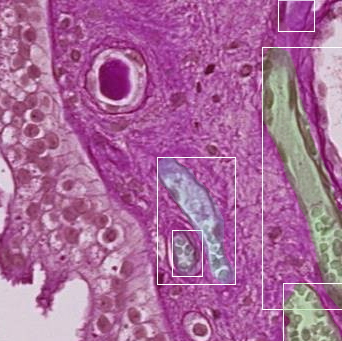

In [70]:
import os
import cv2
import glob
import json
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pycocotools.mask as mask_utils # import encode, decode, frPyObjects, toBbox, area
from sklearn.model_selection import KFold
from itertools import product

for img_id in gt.imgs:
    break
a = random.randint(0, 300)
img_id = list(gt.imgs)[a]
gt.imgs[img_id]
img = cv2.imread(f'/storage/tungnx/dataset_tiny/{img_id}.png')
for ann_id in gt.getAnnIds(imgIds = [img_id]):
    ann_item = gt.anns[ann_id]
    # break
    x, y, w, h = [int(_) for _ in ann_item["bbox"]]
    img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 1)
#     mask = np.zeros(img.shape[:2], dtype = np.uint8)
#     mask = cv2.fillPoly(mask, [np.array(ann_item["segmentation"]).astype(int).reshape(-1, 2)], 1)
    mask = mask_utils.decode(ann_item["segmentation"])
    img[mask != 0] = img[mask != 0] // 4 * 3 + np.random.randint(0, 256, 3).astype(np.uint8) // 4

Image.fromarray(img)